# Machine Learning Project Checklist

1. Frame the problem and look at the big picture.

2. Get the data.

3. Explore the data to gain insights.

4. Explore many different models and short-list the best ones.

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

In [1]:
import os

In [2]:
REPO_DIR = os.path.join(os.environ['USERPROFILE'], 'repos')
PROJ_DIR = os.path.join(REPO_DIR, 'real_estate_machine_learning')
os.chdir(PROJ_DIR)

In [3]:
MODEL_DIR = './model'
DATA_DIR = './data'
PRO_DIR = os.path.join(DATA_DIR, 'processed')
IMG_DIR = os.path.join(DATA_DIR, 'img')

In [4]:
import pandas as pd, numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import src.visualization as viz
from src.utils import *
%matplotlib inline

## Loading processed training dataset for Classification
In the *Preparation* step I have gathered GPS coordinates of:
- Boundaries of Budapest and its sub-districts
- Inhabited areas of Budapest e.g. river, island etc.
- Boundaries of agglomeration of Budapest
- Listed properties for-sale and for-rent in Budapest

Purpose of getting of these datasets is to create a classification model, which can distinguish among 3 classes:
1. Uninhabited area in Budapest
2. Inhabited area in Budapest
3. Area outside of Budapest

In [5]:
train_class = pd.read_csv(os.path.join(PRO_DIR, 'training_class_20181101.csv'), encoding='utf8')
test_class = pd.read_csv(os.path.join(PRO_DIR, 'testing_class_20181101.csv'), encoding='utf8')

In [6]:
train_class.head(3)

,lat,lng,label,label_factor
0,47.513012,19.057450,inhabited_budapest,0
1,47.581464,19.103602,inhabited_budapest,0
2,47.529426,19.125456,inhabited_budapest,0


In [7]:
bound_min_gps=train_class.min()
bound_max_gps=train_class.max()
pic_ratio=(bound_max_gps['lat']-bound_min_gps['lat'])/(bound_max_gps['lng']-bound_min_gps['lng'])
print(pic_ratio)

0.6427371424681457


In [8]:
opt_fig_size=viz.calc_fig_size(pic_ratio, 2.5)

In [9]:
grb = mpl.colors.ListedColormap(np.array(['green', 'red', 'darkblue']))

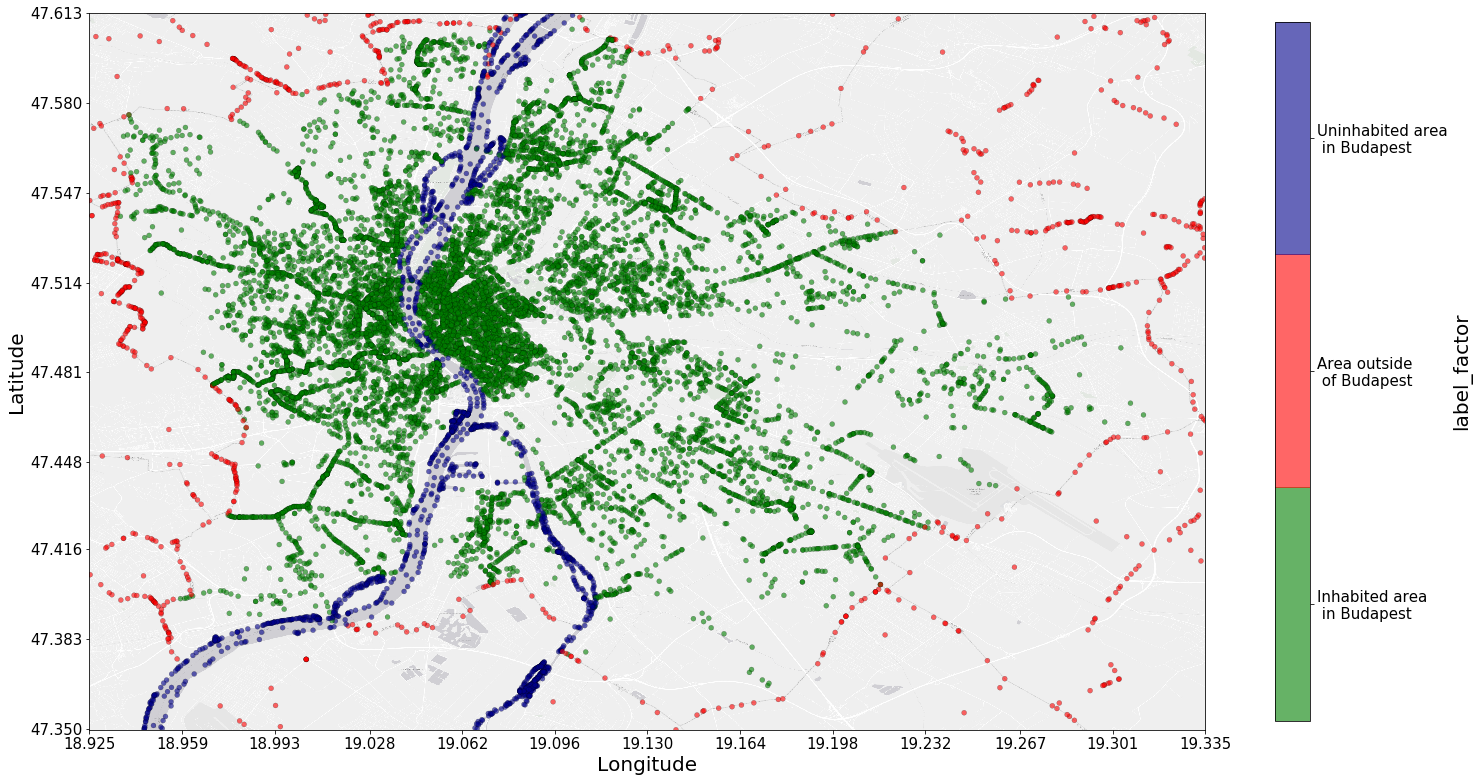

In [10]:
fig, ax = viz.plot_scatter_map(legend_labels=['Inhabited area\n in Budapest', 'Area outside\n of Budapest', 'Uninhabited area\n in Budapest'], x=train_class['lng'], y=train_class['lat'], c=train_class['label_factor'], colormap=grb, cbar=True, c_bar_shrink=0.8, xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, dpi=160, alpha=0.6)

In [11]:
fig.savefig(os.path.join(IMG_DIR, 'budapest.png'), bbox_inches = 'tight')

Class probabilities, for bechmark:

In [117]:
len(train_class)

15229

In [115]:
class_p = train_class[['label', 'label_factor']].groupby('label').count()/len(train_class)
class_p.sort_values('label_factor', ascending=False).applymap(lambda x: '{0:.2%}'.format(x))

,label_factor
label,
inhabited_budapest,83.03%
uninhabited,11.05%
outside_of_budapest,5.92%


In [114]:
class_p.sort_values('label_factor', ascending=False)

,label_factor
label,
inhabited_budapest,0.830258
uninhabited,0.110513
outside_of_budapest,0.059229


### K-Neighbors Classification:
Defining the model, and searching for the best parameter

In [118]:
neigh_cls = load_pkl(os.path.join(MODEL_DIR, 'neigh_cls_98.pkl'))

In [13]:
neigh_cls = KNeighborsClassifier(weights='distance', p=2, n_jobs=-1, n_neighbors=5)

In [14]:
gs = GridSearchCV(estimator=neigh_cls, param_grid={'n_neighbors':[1,3,5,9,17,25], 'weights':['distance'], 'p':[2]}, n_jobs=-1, cv=15, return_train_score=True)

Splitting for explanatory and dependent variables:

In [121]:
X_train_class, y_train_class = train_class[['lat', 'lng']], train_class['label'] 

Loading training data for parameter searching:

In [14]:
gs.fit(X=X_train_class, y=y_train_class)

GridSearchCV(cv=15, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 3, 5, 9, 17, 25], 'weights': ['distance'], 'p': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Evaluation of the scores of the different *k* parameter:

In [15]:
gs.cv_results_

{'mean_fit_time': array([0.05512002, 0.04992015, 0.05200005, 0.06656013, 0.06864012,
        0.06760012]),
 'mean_score_time': array([0.11648029, 0.11544015, 0.12168021, 0.11856025, 0.1404002 ,
        0.1289602 ]),
 'mean_test_score': array([0.98699849, 0.98529122, 0.98483157, 0.9840436 , 0.98095738,
        0.9796441 ]),
 'mean_train_score': array([1., 1., 1., 1., 1., 1.]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 9, 17, 25],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[2, 2, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['distance', 'distance', 'distance', 'distance',
                    'distance', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1, 'p'

In [119]:
gs.cv_results_['mean_test_score']

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

The k-neighbors classifier with the different *k* parameters perform pretty similar both on the training and validation, although the accuracy is declining by increasing *k* parameter. Defining the model and setting the *k* parameter:

In [17]:
neigh_cls = KNeighborsClassifier(weights='distance', p=2, n_jobs=-1, n_neighbors=1)
neigh_cls.fit(X=X_train_class, y=y_train_class)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='distance')

Cross validation using k-folds:

In [122]:
cross_score = cross_val_score(cv=20, estimator=neigh_cls, X=X_train_class, y=y_train_class)

In [125]:
cross_score.mean(), cross_score.std() 

(0.9868683448122105, 0.003616356255360443)

In [19]:
cls_vs_benchmark = cross_score.mean() - class_p.max().values[0]
print('Model was more accurate than the benchmark with {0:+.3%}'.format(cls_vs_benchmark))

Model was more accurate than the benchmark with +15.661%


Validation using testing dataset:

In [20]:
X_test_class, y_test_class = test_class[['lat', 'lng']], test_class['label'] 

In [21]:
test_score = neigh_cls.score(X=X_test_class, y=y_test_class)
print('Model accuracy on testing dataset: {0:.3%}'.format(test_score))

Model accuracy on testing dataset: 98.845%


Saving the model:

In [22]:
save_pkl(obj=neigh_cls, pkl_path=os.path.join(MODEL_DIR, 'neigh_cls.pkl'))

'./model\\neigh_cls.pkl'

Making predictions, label and probability:

In [47]:
np.array([[47.485053, 19.053489],[47.482102, 19.053115]])

array([[47.485053, 19.053489],
       [47.482102, 19.053115]])

In [67]:
latitude_0, longitude_0 = 47.485053, 19.053489
latitude_1, longitude_1 = 47.482102, 19.053115

In [16]:
lat, lng = 47.485053, 19.053489

In [68]:
np.array([[latitude_0, longitude_0], [latitude_1, longitude_1]])

array([[47.485053, 19.053489],
       [47.482102, 19.053115]])

In [69]:
neigh_cls.classes_, neigh_cls.predict_proba(X=[[latitude_0, longitude_0], [latitude_1, longitude_1]])

(array(['inhabited_budapest', 'outside_of_budapest', 'uninhabited'],
       dtype=object), array([[0., 0., 1.],
        [1., 0., 0.]]))

In [70]:
neigh_cls.predict(X=[[latitude_0, longitude_0], [latitude_1, longitude_1]])

array(['uninhabited', 'inhabited_budapest'], dtype=object)

In [79]:
fs = np.array((15.0, 14.0625))*0.8

In [80]:
fs.tolist()

[12.0, 11.25]

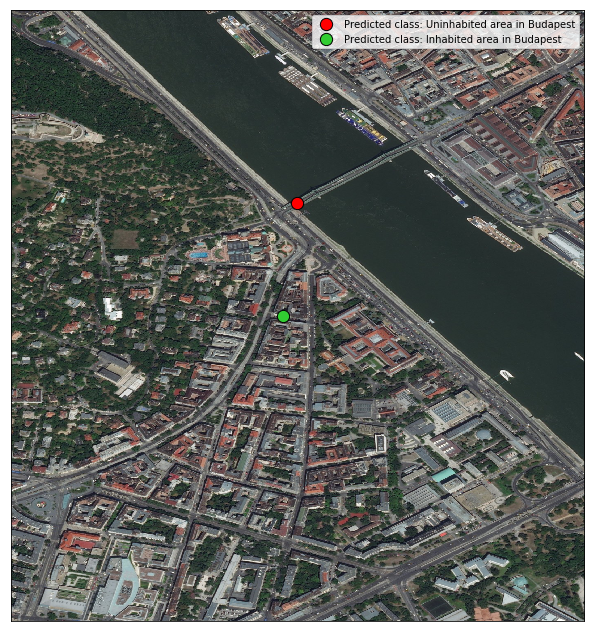

In [95]:
fig, ax = viz.create_background_map(x=np.array([longitude_0+0.0075, longitude_0-0.0075]), y=np.array([latitude_1+0.008, latitude_1-0.008]), figsize=fs.tolist(), dpi=180, service='World_Imagery')
# ax.scatter((longitude_0, longitude_1), (latitude_0, latitude_1), c=['r', 'g'], s=150, edgecolors='Black')
ax.scatter(longitude_0, latitude_0, c='r', s=150, edgecolors='Black')
ax.scatter(longitude_1, latitude_1, c='limegreen', s=150, edgecolors='Black')
ax.legend(['Predicted class: Uninhabited area in Budapest', 'Predicted class: Inhabited area in Budapest'])
plt.show()
# shrink=0.05,

In [96]:
fig.savefig(os.path.join(IMG_DIR, 'class_test.png'), bbox_inches = 'tight')